In [10]:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

In [11]:
dataDir='.'
dataType='val2017'
annFile='{}/annotations_trainval2017/annotations/instances_{}.json'.format(dataDir,dataType) # modify in need


In [12]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [13]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

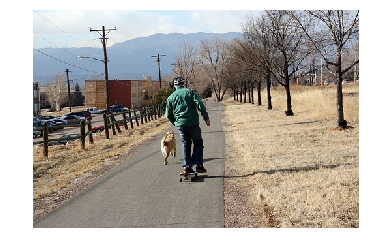

In [14]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [26]:
def iou(x, ys):
            """
            Calculate intersection-over-union overlap
            Params:
            ----------
            x : numpy.array
                single box [xmin, ymin ,xmax, ymax]
            ys : numpy.array
                multiple box [[xmin, ymin, xmax, ymax], [...], ]
            Returns:
            -----------
            numpy.array
                [iou1, iou2, ...], size == ys.shape[0]
            """
            if len(ys.shape) > 1:
                ixmin = np.maximum(ys[:, 0], x[0])
                iymin = np.maximum(ys[:, 1], x[1])
                ixmax = np.minimum(ys[:, 2], x[2])
                iymax = np.minimum(ys[:, 3], x[3])
            else:
                ixmin = np.maximum(ys[0], x[0])
                iymin = np.maximum(ys[1], x[1])
                ixmax = np.minimum(ys[2], x[2])
                iymax = np.minimum(ys[3], x[3])
            iw = np.maximum(ixmax - ixmin, 0.)
            ih = np.maximum(iymax - iymin, 0.)
            inters = iw * ih
            if len(ys.shape) > 1:
                uni = (x[2] - x[0]) * (x[3] - x[1]) + (ys[:, 2] - ys[:, 0]) * \
                    (ys[:, 3] - ys[:, 1]) - inters
            else:
                uni = (x[2] - x[0]) * (x[3] - x[1]) + (ys[2] - ys[0]) * \
                (ys[3] - ys[1]) - inters
            ious = inters / uni
            if len(ys.shape) > 1:
                ious[uni < 1e-12] = 0  # in case bad boxes
            else:
                ious = ious * (uni > 1e-12)
            return ious
    
def iou_coco(lbx, rbxs):
    """
    IOU for coco dataset.
    lbx: bbox, often for gt
    rbx: multiple bboxes.
    """
    x = np.array([lbx[0], lbx[1], lbx[0] + lbx[2], lbx[1] + lbx[3]])
    ys = rbxs.copy()
    if len(ys.shape) > 1:
        ys[:,2] = rbxs[:, 0] + rbxs[:,2]
        ys[:,3] = rbxs[:, 1] + rbxs[:,3]
    else:
        ys[2]= rbxs[0] + rbxs[2]
        ys[3] = rbxs[1] + rbxs[3]
    ious = iou(x, ys)
    return ious

In [27]:
x = np.array([0,0,4,4,])
y = np.array([[1,1,3,2], [1,1,6,6]])

In [28]:
iou(x, y), iou(x, y[0, :])

(array([0.125  , 0.28125]), 0.125)

In [30]:
iou_coco(x,y), iou_coco(x, y[0, :])
y[0,:]

array([1, 1, 3, 2])

In [31]:
def af2lst():
    """
    func for converting coco screened by afutofocus to lst format
    """
    
    pass

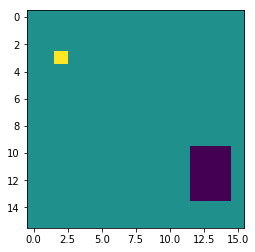

In [34]:
def affine_fmap2gt(fmap_size, input_size, gts, lthres, rthres):
    """
    func for affine fmap grid to original image and calc iou with gt 
    fmap_size: (x, y), 2-sdim size of the output image
    """
    out_lbl = np.zeros(fmap_size)
    orig_size = input_size
    scal_fact = (input_size[0] / fmap_size[0], input_size[1] / fmap_size[1])
    h, w = fmap_size # you cannot be too careful
    for eh in range(h):
        for ew in range(w):
            affined_box = np.array([scal_fact[0]*eh, scal_fact[1]*ew, scal_fact[0], scal_fact[1]])
            affined_ious = iou_coco(affined_box, gts)
            if max(affined_ious) > 0:
                assigned_gt = gts[np.argmax(affined_ious), :] #[x, y, w, h]
                gt_area = assigned_gt[2] * assigned_gt[3] 
                if gt_area > lthres and gt_area < rthres:
                    out_lbl[eh, ew] = 1
                else:
                    out_lbl[eh, ew] = -1
            else:
                out_lbl[eh, ew] = 0
    return out_lbl


input_size = [480, 640]
fmap_size = [16,16]
gts = np.array([[100, 110, 10, 10], [300, 500, 100, 100]])
lthres, rthres = 9**2, 64**2
lbls = affine_fmap2gt(fmap_size, input_size, gts, lthres, rthres)
plt.imshow(lbls);plt.show()

In [ ]:
input_size = [480, 640]
fmap_size = [16,16]
gts = np.array([[100, 110, 10, 10], [300, 500, 40, 40]])
lthres, rthres = 9**2, 64**2
lbls = affine_fmap2gt(fmap_size, input_size, gts, lthres, rthres)
plt.imshow(lbls);plt.show()